# Bump Dataset

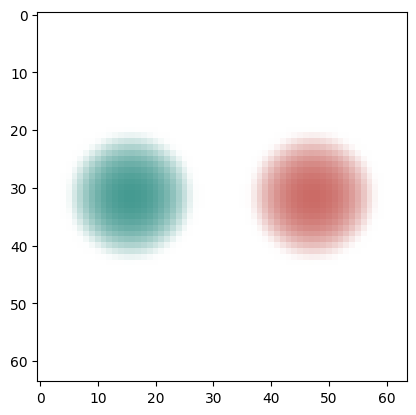

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# range where the bump functions are evaluated
x_min, x_max = 0, 5
y_min, y_max = 0, 5

# Image size will be num_pixels x num_pixels
num_pixels = 64

# points where the bump functions will be evaluated
X_evals, Y_evals = np.meshgrid(np.linspace(x_min, x_max, num_pixels), np.linspace(y_min, y_max, num_pixels))

# colors
color1 = np.array([69,154,145])
color2 = np.array([203,107,102])
white = np.array([255,255,255])

def bump2D(x_center, y_center, x_eval, y_eval, temp=1):
  r2 = (x_eval - x_center)**2 + (y_eval - y_center)**2
  return np.where(np.sqrt(r2) < 1, np.exp(temp) * np.exp(-temp / (1 - r2)), 0)

def render_img(x1, y1, x2, y2):
  bump1 = bump2D(x1, y1, X_evals, Y_evals)
  bump2 = bump2D(x2, y2, X_evals, Y_evals)
  img = (1 - bump1[:,:, None] - bump2[:,:, None]) * white + bump1[:,:, None] * color1 + bump2[:, :, None] * color2
  return img.astype(np.int32)

img = render_img(5*0.25, 2.5, 5*0.75, 2.5)

plt.imshow(img)

<ipython-input-1-38e9c1b4b2ef>:21: RuntimeWarning: overflow encountered in exp
  return np.where(np.sqrt(r2) < 1, np.exp(temp) * np.exp(-temp / (1 - r2)), 0)


[0.9448462202379404, 0.5289438164103516]


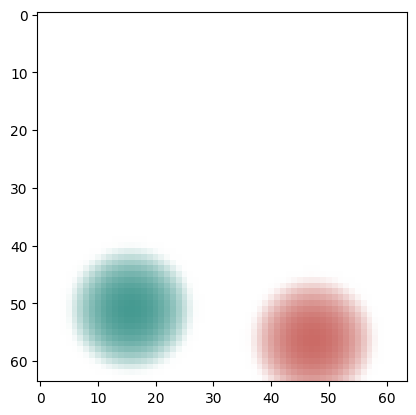

[2.2669956499446444, 0.05159280219543705]


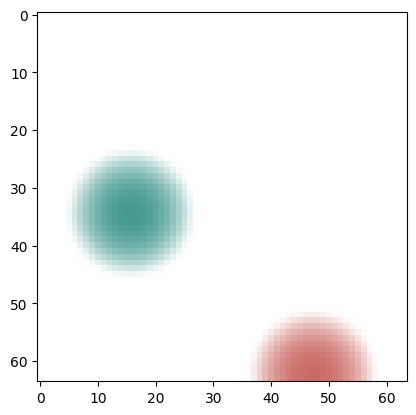

[0.4323802837336732, 2.2932424627854937]


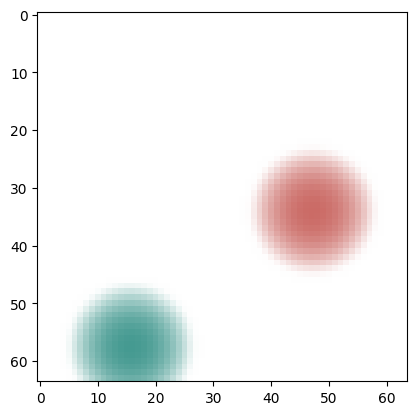

[2.2084205080247923, 3.862418109208019]


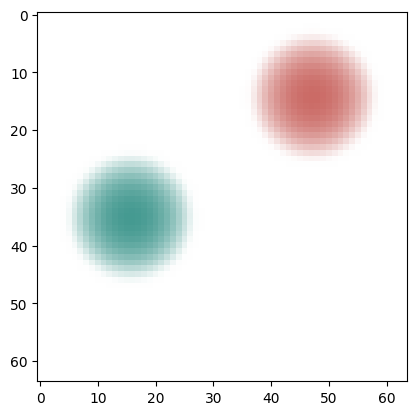

[3.9629716333624017, 1.8592170346414727]


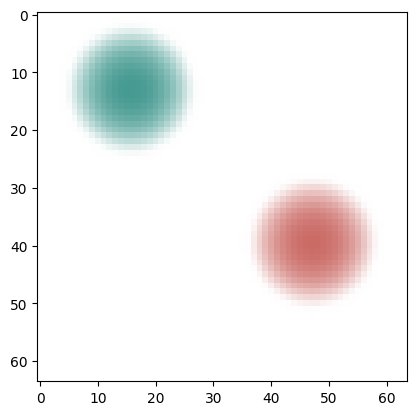

<Figure size 640x480 with 0 Axes>

In [ ]:
def sample_L_distribution():
  # rejection sampling
  while True:
    y1 = np.random.uniform(0, 5)
    y2 = np.random.uniform(0, 5)
    if y1 <= 2.5 or y2 <= 2.5:
      return render_img(5*0.25, 5 - y1, 5*0.75, 5 - y2), [y1, y2]

for i in range(5):
  img, z = sample_L_distribution()
  print(z)
  plt.imshow(img)
  plt.show()
  plt.clf()


### Note on overflow warning
Overflow happens when -1/(1 - r2) gets very close to minus infinity because r2 is close to 1. The overflow does not always show up, depending on where the ball is positioned (and how fine the resolution is). It is safe to ignore warning since in that case np.exp will evaluate to zero, as wanted.

Also note that np.where(condition, x, y) evaluates both arrays x and y fully (not just where the condition is satisfied.

# Testing "sufficient nonlinearity" (Assumption 2) numerically

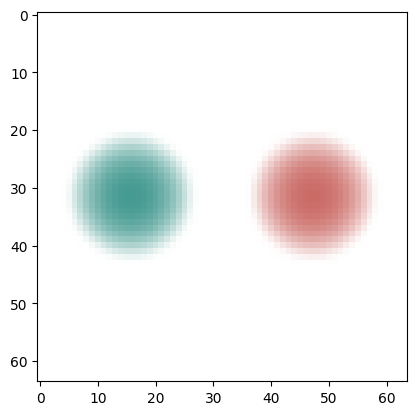

Norm of first order derivative


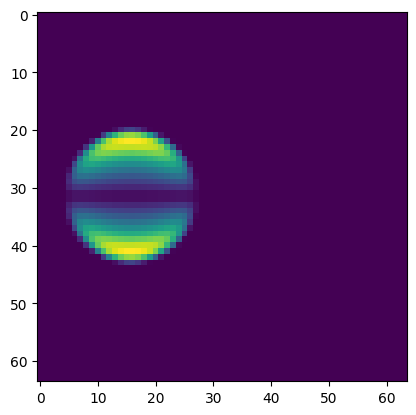

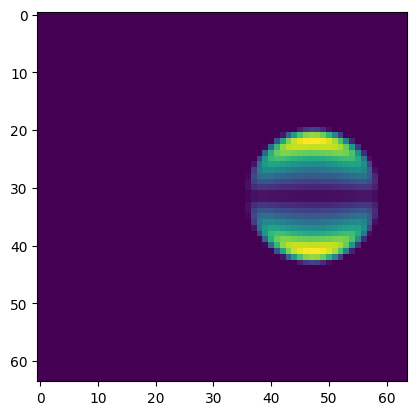

Norm of second order derivative


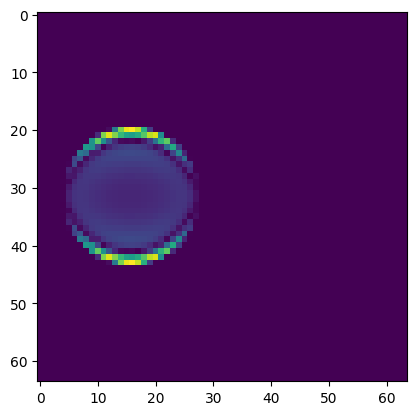

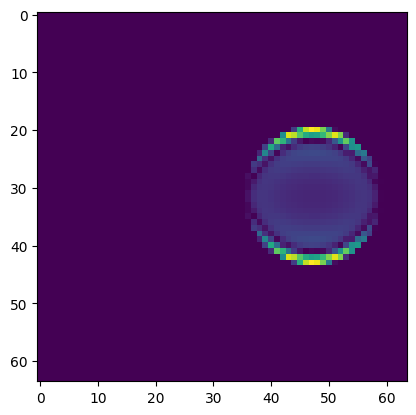

<Figure size 640x480 with 0 Axes>

In [ ]:
# The above is copy-pasted from above and formulated in jnp instead of np to allow for autodiff
import jax.numpy as jnp
from jax import jacfwd
import matplotlib.pyplot as plt

# range where the bump functions are evaluated
x_min, x_max = 0, 5
y_min, y_max = 0, 5

# Image size will be num_pixels x num_pixels
num_pixels = 64

# points where the bump functions will be evaluated
X_evals, Y_evals = jnp.meshgrid(jnp.linspace(x_min, x_max, num_pixels), jnp.linspace(y_min, y_max, num_pixels))

# colors
color1 = jnp.array([69,154,145])
color2 = jnp.array([203,107,102])
white = jnp.array([255,255,255])

def bump2D(x_center, y_center, x_eval, y_eval, temp=1):
  r2 = (x_eval - x_center)**2 + (y_eval - y_center)**2
  return jnp.where(jnp.sqrt(r2) < 1, jnp.exp(temp) * jnp.exp(-temp / (1 - r2)), 0)

def bump1(y):
  return white + bump2D(5*0.25, y, X_evals, Y_evals)[:, :, None]*(color1 - white)

def bump2(y):
  return bump2D(5*0.75, y, X_evals, Y_evals)[:, :, None]*(color2 - white)

def render_img(y1, y2):
  return bump1(y1) + bump2(y2)

img = render_img(2.5, 2.5)

# plot image
plt.imshow(img.astype(np.int32))
plt.show()
plt.clf()

# compute and plot 1st derivative
diff_bump1 = jacfwd(bump1)
diff_bump2 = jacfwd(bump2)

diff_plot1 = jnp.linalg.norm(diff_bump1(2.5), axis=2)
diff_plot2 = jnp.linalg.norm(diff_bump2(2.5), axis=2)

print("Norm of first order derivative")
plt.imshow(diff_plot1)
plt.show()
plt.clf()
plt.imshow(diff_plot2)
plt.show()
plt.clf()

# compute and plot 2nd derivative
diff2_bump1 = jacfwd(diff_bump1)
diff2_bump2 = jacfwd(diff_bump2)

diff2_plot1 = jnp.linalg.norm(diff2_bump1(2.5), axis=2)
diff2_plot2 = jnp.linalg.norm(diff2_bump2(2.5), axis=2)

print("Norm of second order derivative")
plt.imshow(diff2_plot1)
plt.show()
plt.clf()
plt.imshow(diff2_plot2)
plt.show()
plt.clf()



In [ ]:
# WARNING this cells takes > 10min to run...
# verify 2nd assumption.

def compute_W(y1, y2):
  ### normalizing the columns (otherwise the scale does not mean anything...) ###
  diff_bump1_flat = diff_bump1(y1).flatten()
  diff_bump1_norm = diff_bump1_flat / jnp.linalg.norm(diff_bump1_flat)
  diff2_bump1_flat = diff2_bump1(y1).flatten()
  diff2_bump1_norm = diff2_bump1_flat / jnp.linalg.norm(diff2_bump1_flat)

  diff_bump2_flat = diff_bump2(y2).flatten()
  diff_bump2_norm = diff_bump2_flat / jnp.linalg.norm(diff_bump2_flat)
  diff2_bump2_flat = diff2_bump2(y2).flatten()
  diff2_bump2_norm = diff2_bump2_flat / jnp.linalg.norm(diff2_bump2_flat)

  return jnp.stack([diff_bump1_norm, diff2_bump1_norm, diff_bump2_norm, diff2_bump2_norm]).T

def compute_detWtW(y1, y2):
  W = compute_W(y1, y2)
  return jnp.linalg.det(W.T@W)

compute_detWtW(2.5, 2.5)

delta = 0.05
range1 = jnp.arange(0, 5, delta)
range2 = jnp.arange(0, 5, delta)
Z1, Z2 = jnp.meshgrid(range1, range2)
detWtW = np.zeros((len(range2),len(range1)))
for i in range(len(range2)):
  for j in range(len(range1)):
    detWtW[i,j] = compute_detWtW(Z1[i,j], Z2[i,j])


In [ ]:
print(jnp.sqrt(jnp.abs(detWtW)).min(), jnp.sqrt(jnp.abs(detWtW)).max())

0.9715633 1.0000002


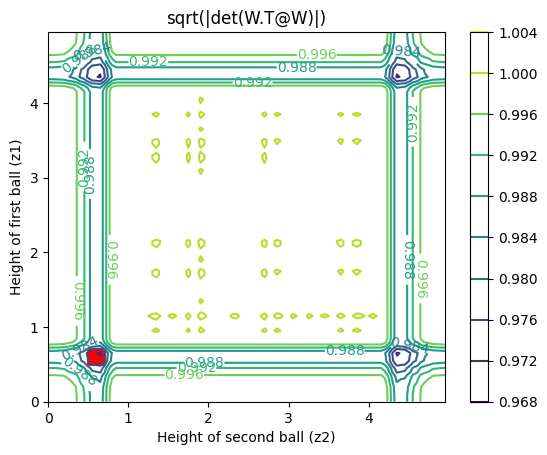

In [ ]:
import matplotlib

fig, ax = plt.subplots()
ax.add_patch(matplotlib.patches.Rectangle((.5, .5), .2, .2, edgecolor='red', facecolor='red', linewidth=2))
CS = ax.contour(Z1, Z2, jnp.sqrt(jnp.abs(detWtW)))
ax.clabel(CS)
ax.set_title('sqrt(|det(W.T@W)|)')
ax.set_ylabel("Height of first ball (z1)")
ax.set_xlabel("Height of second ball (z2)")
fig.colorbar(CS)


In [ ]:
# WARNING this cell takes > 10min to run...
# verify 2nd assumption. (zooming on potential singularity)

delta = 0.001
range1 = jnp.arange(0.5, 0.7, delta)
range2 = jnp.arange(0.5, 0.7, delta)
Z1_zoom, Z2_zoom = jnp.meshgrid(range1, range2)
detWtW_zoom = np.zeros((len(range2),len(range1)))
for i in range(len(range2)):
  for j in range(len(range1)):
    detWtW_zoom[i,j] = compute_detWtW(Z1_zoom[i,j], Z2_zoom[i,j])

In [ ]:
print(jnp.sqrt(jnp.abs(detWtW_zoom)).min(), jnp.sqrt(jnp.abs(detWtW_zoom)).max())

0.9708805 0.9788254


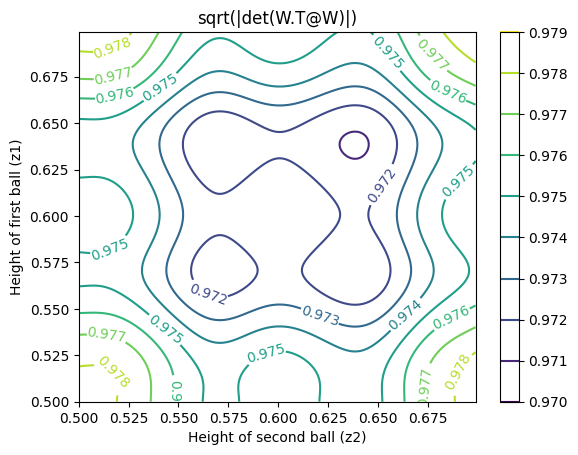

In [ ]:
fig, ax = plt.subplots()
CS = ax.contour(Z1_zoom, Z2_zoom, jnp.sqrt(jnp.abs(detWtW_zoom)))
ax.clabel(CS)
ax.set_title('sqrt(|det(W.T@W)|)')
ax.set_ylabel("Height of first ball (z1)")
ax.set_xlabel("Height of second ball (z2)")
fig.colorbar(CS)